In [8]:
!pip install yfinance
!pip install yahooquery
!pip install tvdatafeed
!pip install tensorflow
!pip install mplfinance
!pip install cairocffi
from tvDatafeed import TvDatafeed, Interval
from yahooquery import Screener
import yfinance as yf   
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import random 
from tensorflow.keras.models import load_model
import os
import shutil
import mplfinance as mpl 
from datetime import datetime
import glob
from PIL import Image
import cv2
%matplotlib notebook
import gc
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('agg')
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense,AveragePooling2D,GlobalAveragePooling2D
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
def work_with_dir():
  if os.path.exists("/content/data/"):
    shutil.rmtree("/content/data/", ignore_errors=True)
    print("Data Folder Removed")
    os.mkdir("/content/data/")
  if not os.path.exists("/content/data/"):
    os.mkdir("/content/data/")
  if not os.path.exists("/content/extracted/"):
    os.mkdir("/content/extracted/")
  if not os.path.exists("/content/checkpoints/"):
    os.mkdir("/content/checkpoints/")

def get_crypto_syms():
   screens = [
       'all_cryptocurrencies_us', 'all_cryptocurrencies_au', 'all_cryptocurrencies_ca', 'all_cryptocurrencies_eu', 'all_cryptocurrencies_gb', 'all_cryptocurrencies_in', ]
   s = Screener()
   symbols = []
   for i in screens:
      data = s.get_screeners(i, count=250)
      dicts = data[i]['quotes']
      syms = [d['symbol'] for d in dicts]
      for sym in syms:
        symbols.append(sym)
   return symbols

def download_data(symbols, periodd, intervall):
  indexx = 100
  work_with_dir()
  for symbol in symbols:
    if ((symbols.index(symbol)+1) % 100 == 0):
      print(f" -- {indexx}", end="")
      indexx = indexx + 100
    try:
        data = yf.download(symbol, period=periodd,
                           interval=intervall, progress=False, show_errors=False)
        if data.empty:
           pass
        else:
            data.to_csv(f"/content/data/{symbol}.csv")
    except:
       print("Error!")
  print(" ")

def extract_data(how_many_future_candles, how_many_past_candles, each_row_past):
  print(f"Files In Data : {len(os.listdir('/content/data/'))}")
  pd.options.mode.chained_assignment = None
  files = os.listdir("/content/data/")
  print("Processing File:")
  now = datetime.now().strftime("%H%M%S")
  os.mkdir(f"/content/extracted/{now}/")
  index = 1
  for file in files:
     print(f"File Number {index}:", end=" ")
     each_file_proc(file, now, how_many_future_candles,
                    how_many_past_candles, each_row_past)
     index = index + 1
  print(" ")
  return now

def each_file_proc(file, now, how_many_future_candles, how_many_past_candles, each_row_past):

    address = f"/content/data/{file}"
    data = pd.read_csv(address)

    if len(data.columns) == 7:
      data = data.iloc[:, 1:]

    data = np.array(data)
    data = data.astype(float)
    max_index = data.shape[0]-which_future_or_past
    for i in range(each_row_past,max_index):

        rows = data[i-each_row_past:i, :]
        past_candles = []
        for z in range(1, how_many_past_candles+1):
          past_candles.append((data[i-z][3]+data[i-z][0])/2)
        past_candles = sum(past_candles)/len(past_candles)
        next_candles = []
        for z in range(0, how_many_future_candles):
          next_candles.append((data[i+z][3]+data[i+z][0])/2)
        next_candles = sum(next_candles)/len(next_candles)
        if next_candles > past_candles:
          sugg = 1
        else:
          sugg = 0

        df = pd.DataFrame(rows, columns=["Open", "High", "Low", "Close","Adj Close","Volume"])

        df.index.name = "Date"

        df.index = pd.to_datetime(df.index)
        right_now = datetime.now().strftime("%H%M%S%f")
        address = f"/content/extracted/{now}/{right_now}_{sugg}.png"
        

        fig, _a = mpl.plot(df, type="candle", style="yahoo", axisoff=True,
                            returnfig=True, tight_layout=True,figsize =(1.5,1.5))
        
        fig.savefig(address)
        fig.clf()

        if i % 10 == 0:
            print(f"{i}/{max_index}", end=" ")
        if i % 20:
          plt.close("all")
        if i % 270 ==0:
          print("")
    plt.close("all")
    print("")

def start(how_many_future_candles, how_many_past_candles, each_row_past):
    folder_name = extract_data(
        how_many_future_candles, how_many_past_candles, each_row_past)
    return folder_name

In [10]:
symbols = get_crypto_syms()
print(f"Symbols : {len(symbols)}")
#symbols = ["btc-usd","eth-usd","trx-usd","ltc-usd","xrp-usd","bnb-usd"]
download_data(symbols,"max","1mo")

Symbols : 1500
Data Folder Removed
 -- 100 -- 200 -- 300 -- 400 -- 500 -- 600 -- 700 -- 800 -- 900 -- 1000 -- 1100 -- 1200 -- 1300 -- 1400 -- 1500 


In [11]:
how_many_future_candles = 3
how_many_past_candles = 1
each_row_past = 35


global which_future_or_past
which_future_or_past = None
if how_many_future_candles > how_many_past_candles:
    which_future_or_past = how_many_future_candles
else:
    which_future_or_past = how_many_past_candles
folder_name = start(how_many_future_candles,how_many_past_candles,each_row_past)
len(os.listdir(f"/content/extracted/{folder_name}"))

Files In Data : 1500
Processing File:
File Number 1: 
File Number 2: 40/86 50/86 60/86 70/86 80/86 
File Number 3: 
File Number 4: 
File Number 5: 40/51 50/51 
File Number 6: 
File Number 7: 40/54 50/54 
File Number 8: 40/55 50/55 
File Number 9: 
File Number 10: 40/54 50/54 
File Number 11: 40/54 50/54 
File Number 12: 
File Number 13: 40/46 
File Number 14: 40/54 50/54 
File Number 15: 40/43 
File Number 16: 40/48 
File Number 17: 
File Number 18: 
File Number 19: 40/45 
File Number 20: 40/55 50/55 
File Number 21: 40/54 50/54 
File Number 22: 
File Number 23: 
File Number 24: 
File Number 25: 40/55 50/55 
File Number 26: 40/54 50/54 
File Number 27: 
File Number 28: 
File Number 29: 40/54 50/54 
File Number 30: 40/54 50/54 
File Number 31: 40/54 50/54 
File Number 32: 40/92 50/92 60/92 70/92 80/92 90/92 
File Number 33: 40/54 50/54 
File Number 34: 40/49 
File Number 35: 
File Number 36: 40/54 50/54 
File Number 37: 
File Number 38: 40/49 
File Number 39: 
File Number 40: 
File Numb

16279

In [12]:
#folder_name = "090633"

shutil.make_archive(folder_name,"zip",f"/content/extracted/{folder_name}/")
#shutil.unpack_archive(f"/content/{folder_name}.zip",f"/content/extracted/{folder_name}")
label = []
data  = []
files = os.listdir(f"/content/extracted/{folder_name}/")
for i, image_name in enumerate(files):
  if image_name.split(".")[1] == "png":
    image = cv2.imread(f"/content/extracted/{folder_name}"+"/"+image_name,0)
    dim = (100, 100)
    resized = cv2.resize(image, dim)
    data.append(np.array(resized))
    sugg = image_name.split("_")[1].split(".")[0]
    label.append(int(sugg))
data = np.array(data)
data = data / 255
print(data.shape)
xTrain , xTest , yTrain , yTest = train_test_split(data,label,test_size=0.2,random_state=99)
data = None
label = None
print(f"xTrain : {len(xTrain)} \\ xTest : {len(xTest)}")
nytrain = []
nytest = []
yn = 0
nn = 0
for i in yTrain:
  if i == 1:
    nytrain.append([1,0])
    yn += 1
  else:
    nytrain.append([0,1])
    nn += 1
for i in yTest:
  if i == 1:
    nytest.append([1,0])
    yn += 1
  else:
    nytest.append([0,1])
    nn += 1
yTrain = np.array(nytrain)
yTest = np.array(nytest)
print(f"yn: {yn} nn: {nn}")

(16279, 100, 100)
xTrain : 13023 \ xTest : 3256
yn: 7434 nn: 8845


In [13]:
model = Sequential()

model.add(Conv2D(128,    (3, 3),activation="relu", input_shape=(xTrain.shape[1], xTrain.shape[2],1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(100,     (3, 3),activation="relu",)) 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(100,     (3, 3),activation="relu",)) 
model.add(Conv2D(64,     (2, 2),activation="relu",)) 
model.add(Flatten())
model.add(Dense(750,activation="relu"))
model.add(Dense(750,activation="relu"))
model.add(Dense(750,activation="relu"))
model.add(Dense(2,activation="sigmoid"))

adamax = tf.keras.optimizers.Adamax(
    learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=adamax,
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 98, 98, 128)       1280      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 49, 49, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 47, 47, 100)       115300    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 23, 100)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 21, 21, 100)       90100     
                                                                 
 conv2d_7 (Conv2D)           (None, 20, 20, 64)       

In [ ]:
filepath = "/content/checkpoints/{epoch:02d}-{val_accuracy:.2f}.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#model.fit(xTrain,yTrain,batch_size=64,epochs=30,validation_data=(xTest,yTest), callbacks=model_checkpoint_callback)
model.fit(xTrain,yTrain,batch_size=16,epochs=20,validation_data=(xTest,yTest))


Epoch 1/20
752/814 [==========================>...] - ETA: 1:04 - loss: 0.5516 - accuracy: 0.7089

In [ ]:
model.save(f"1.h5")

In [63]:
symbol,period,interval="btc-usd","10d","1h"
data = yf.download(tickers=symbol,period=period,interval=interval)
data = np.array(data)
data = data.astype(float)
yf.download(tickers=symbol,period=period,interval=interval)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
2022-07-18 00:00:00+00:00,20796.238281,20897.701172,20796.238281,20819.878906,20819.878906,0
2022-07-18 01:00:00+00:00,20820.755859,20972.000000,20820.755859,20972.000000,20972.000000,248926208
2022-07-18 02:00:00+00:00,20971.796875,21297.218750,20969.765625,21297.218750,21297.218750,1256941568
2022-07-18 03:00:00+00:00,21311.029297,21328.630859,21213.888672,21274.400391,21274.400391,341579776
2022-07-18 04:00:00+00:00,21278.574219,21285.886719,21190.080078,21269.126953,21269.126953,323989504
...,...,...,...,...,...,...
2022-07-27 07:00:00+00:00,21247.427734,21414.771484,21247.427734,21336.742188,21336.742188,464347136
2022-07-27 08:00:00+00:00,21345.966797,21406.253906,21345.966797,21367.925781,21367.925781,113274880
2022-07-27 09:00:00+00:00,21363.759766,21363.759766,21297.115234,21297.115234,21297.115234,117422080
2022-07-27 10:00:00+00:00,21299.728516,21324.660156,21276.152344,21319.873047,21319.873047,54032384


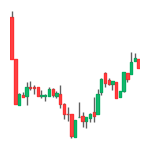

In [64]:
i = -2
rows = data[i-each_row_past:i, :]
df = pd.DataFrame(rows, columns=["Open", "High", "Low", "Close","Adj Close","Volume"])
df.index.name = "Date"
df.index = pd.to_datetime(df.index)
fig, _a = mpl.plot(df, type="candle", style="yahoo", axisoff=True,
                            returnfig=True, tight_layout=True,figsize =(1.5,1.5))
fig.savefig("btctobepred.png")

In [65]:
image = cv2.imread("/content/btctobepred.png",0)
dim = (100, 100)
resized = cv2.resize(image, dim)
data = np.array(resized)

In [66]:
model.predict([[data.reshape(1,100,100,1)]])

array([[0., 1.]], dtype=float32)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')